## Preparing data

In [0]:
# Mount base directory
data_BASE_DIR = "dbfs:/mnt/mids-w261/"
display(dbutils.fs.ls(f"{data_BASE_DIR}"))

path,name,size,modificationTime
dbfs:/mnt/mids-w261/HW5/,HW5/,0,1763056353429
dbfs:/mnt/mids-w261/OTPW_12M/,OTPW_12M/,0,1763056353429
dbfs:/mnt/mids-w261/OTPW_1D_CSV/,OTPW_1D_CSV/,0,1763056353429
dbfs:/mnt/mids-w261/OTPW_36M/,OTPW_36M/,0,1763056353429
dbfs:/mnt/mids-w261/OTPW_3M/,OTPW_3M/,0,1763056353429
dbfs:/mnt/mids-w261/OTPW_3M_2015.csv,OTPW_3M_2015.csv,1500620247,1741625185000
dbfs:/mnt/mids-w261/OTPW_3M_2015_delta/,OTPW_3M_2015_delta/,0,1763056353429
dbfs:/mnt/mids-w261/OTPW_60M/,OTPW_60M/,0,1763056353429
dbfs:/mnt/mids-w261/OTPW_60M_Backup/,OTPW_60M_Backup/,0,1763056353429
dbfs:/mnt/mids-w261/airport-codes_csv.csv,airport-codes_csv.csv,6232459,1740508595000


In [0]:
# Load OTPW for 3 months and 1 year
df_otpw_3m = spark.read.format("csv").option("header","true").load(f"dbfs:/mnt/mids-w261/OTPW_3M_2015.csv")
df_otpw_1y = spark.read.format("csv").option("header","true").load(f"dbfs:/mnt/mids-w261/OTPW_12M/OTPW_12M/OTPW_12M_2015.csv.gz")

print("3-month rows:", df_otpw_3m.count(), " / columns:", len(df_otpw_3m.columns))
print("1-year  rows:", df_otpw_1y.count(), " / columns:", len(df_otpw_1y.columns))

3-month rows: 1401363  / columns: 216
1-year  rows: 5811854  / columns: 216


In [0]:
# Function to check nulls for a dataframe
from pyspark.sql.functions import col, sum as _sum, when
def null_summary(df):
    total_rows = df.count()

    # Compute null count and percentage per column
    null_summary = df.select([
        _sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
        for c in df.columns
    ]).toPandas().T.reset_index()

    null_summary.columns = ["Column", "Null_Count"] 
    null_summary["Null_%"] = (null_summary["Null_Count"] / total_rows * 100).round(2)

    # Sort by highest missing percentage
    null_summary = null_summary.sort_values(by="Null_%", ascending=False).reset_index(drop=True)

    return null_summary

In [0]:
# Select columns to keep
selected_columns = ['DEP_DELAY_GROUP','QUARTER', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'AIR_TIME','DISTANCE', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_STATE_ABR', 'ORIGIN_WAC','DEP_TIME', 'TAIL_NUM', 'ORIGIN', 'DEST_AIRPORT_ID', 'DEST', 'TAXI_OUT','TAXI_IN','HourlyStationPressure','HourlyDryBulbTemperature','HourlyDewPointTemperature','HourlyRelativeHumidity','HourlyWetBulbTemperature','HourlyWindSpeed']

In [0]:
# Function to select dataframe and columns
def select_df(df, columns):
    return df.select(columns)

In [0]:
# Create dataframe with selected columns
df_3m = select_df(df_otpw_3m, selected_columns)
# Check column null vaules
null_summary(df_3m)

,Column,Null_Count,Null_%
0,AIR_TIME,46601,3.33
1,TAXI_IN,44316,3.16
2,TAXI_OUT,43119,3.08
3,DEP_DELAY_GROUP,42306,3.02
4,DEP_TIME,42306,3.02
5,HourlyWetBulbTemperature,10258,0.73
6,HourlyStationPressure,9624,0.69
7,TAIL_NUM,8187,0.58
8,HourlyRelativeHumidity,4721,0.34
9,HourlyDewPointTemperature,4573,0.33


In [0]:
# Function to drop null values
def drop_null(df, columns):
    return df.dropna(subset=columns)

In [0]:
# Drop null values for some columns
df_3m = drop_null(df_3m, ['DEP_DELAY_GROUP', 'AIR_TIME'])
# Check null values again
null_summary(df_3m)
#

,Column,Null_Count,Null_%
0,HourlyWetBulbTemperature,9737,0.72
1,HourlyStationPressure,9132,0.67
2,HourlyRelativeHumidity,4523,0.33
3,HourlyWindSpeed,4467,0.33
4,HourlyDewPointTemperature,4379,0.32
5,HourlyDryBulbTemperature,4266,0.31
6,DEP_DELAY_GROUP,0,0.00
7,QUARTER,0,0.00
8,ORIGIN_AIRPORT_ID,0,0.00
9,DISTANCE,0,0.00


In [0]:
# Check columns scheme
df_3m.printSchema()

root
 |-- DEP_DELAY_GROUP: string (nullable = true)
 |-- QUARTER: string (nullable = true)
 |-- DAY_OF_MONTH: string (nullable = true)
 |-- DAY_OF_WEEK: string (nullable = true)
 |-- FL_DATE: string (nullable = true)
 |-- AIR_TIME: string (nullable = true)
 |-- DISTANCE: string (nullable = true)
 |-- ORIGIN_AIRPORT_ID: string (nullable = true)
 |-- ORIGIN_AIRPORT_SEQ_ID: string (nullable = true)
 |-- ORIGIN_STATE_ABR: string (nullable = true)
 |-- ORIGIN_WAC: string (nullable = true)
 |-- DEP_TIME: string (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST_AIRPORT_ID: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- TAXI_OUT: string (nullable = true)
 |-- TAXI_IN: string (nullable = true)
 |-- HourlyStationPressure: string (nullable = true)
 |-- HourlyDryBulbTemperature: string (nullable = true)
 |-- HourlyDewPointTemperature: string (nullable = true)
 |-- HourlyRelativeHumidity: string (nullable = true)
 |-- Hourly

In [0]:
# Convert columns to numeric and date format
columns_format = {
    'DEP_DELAY_GROUP':'float',
    'QUARTER':'int',
    'DAY_OF_MONTH':'int',
    'DAY_OF_WEEK':'int',
    'FL_DATE':'date',
    'AIR_TIME':'float',
    'DISTANCE':'float',
    'ORIGIN_AIRPORT_ID':'int', 
    'ORIGIN_AIRPORT_SEQ_ID':'int', 
    'ORIGIN_STATE_ABR':'string', 
    'ORIGIN_WAC':'int', 
    'DEP_TIME':'float', 
    'TAIL_NUM':'string', 
    'ORIGIN':'string', 
    'DEST_AIRPORT_ID':'int', 
    'DEST':'string', 
    'TAXI_OUT':'float', 
    'TAXI_IN':'float', 
    'HourlyStationPressure':'float',
    'HourlyDryBulbTemperature':'float',
    'HourlyDewPointTemperature':'float',
    'HourlyRelativeHumidity':'float',
    'HourlyWetBulbTemperature':'float',
    'HourlyWindSpeed':'float'
}

In [0]:
# Function to convert columns format
def convert_columns(df, columns):
    return df.select([col(c).cast(columns[c]) for c in df.columns])

In [0]:
df_3m = convert_columns(df_3m, columns_format)
# Check columns scheme
df_3m.printSchema()

root
 |-- DEP_DELAY_GROUP: float (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- FL_DATE: date (nullable = true)
 |-- AIR_TIME: float (nullable = true)
 |-- DISTANCE: float (nullable = true)
 |-- ORIGIN_AIRPORT_ID: integer (nullable = true)
 |-- ORIGIN_AIRPORT_SEQ_ID: integer (nullable = true)
 |-- ORIGIN_STATE_ABR: string (nullable = true)
 |-- ORIGIN_WAC: integer (nullable = true)
 |-- DEP_TIME: float (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST_AIRPORT_ID: integer (nullable = true)
 |-- DEST: string (nullable = true)
 |-- TAXI_OUT: float (nullable = true)
 |-- TAXI_IN: float (nullable = true)
 |-- HourlyStationPressure: float (nullable = true)
 |-- HourlyDryBulbTemperature: float (nullable = true)
 |-- HourlyDewPointTemperature: float (nullable = true)
 |-- HourlyRelativeHumidity: float (nullable = true)
 |-- HourlyWetBu

In [0]:
# Function to create departure delay classification groups
def create_delay_groups(df):
    return df.withColumn(
        'DEP_DELAY_GROUP_CLASSIFIED',
        when(col("DEP_DELAY_GROUP").isin(-2, -1), 'early')
        .when(col("DEP_DELAY_GROUP").isin(0), 'on_time')
        .otherwise('delayed')
    )

# Function to process null values
def process_null_values(df):
    cols_to_impute = [
        "HourlyWetBulbTemperature",
        "HourlyStationPressure",
        "HourlyWindSpeed",
        "HourlyRelativeHumidity",
        "HourlyDewPointTemperature",
        "HourlyDryBulbTemperature",
    ]
    medians = {}
    for c in cols_to_impute:
        median_val = df.approxQuantile(c, [0.5], 0.001)[0]
        medians[c] = median_val
    return df.fillna(medians)

In [0]:
df_3m = create_delay_groups(df_3m)
df_3m = process_null_values(df_3m)

In [0]:
# Check null values again
print(null_summary(df_3m))
# Check sample data
display(df_3m.limit(5))

                        Column  Null_Count  Null_%
0              DEP_DELAY_GROUP           0     0.0
1                      QUARTER           0     0.0
2                 DAY_OF_MONTH           0     0.0
3                  DAY_OF_WEEK           0     0.0
4                      FL_DATE           0     0.0
5                     AIR_TIME           0     0.0
6                     DISTANCE           0     0.0
7            ORIGIN_AIRPORT_ID           0     0.0
8        ORIGIN_AIRPORT_SEQ_ID           0     0.0
9             ORIGIN_STATE_ABR           0     0.0
10                  ORIGIN_WAC           0     0.0
11                    DEP_TIME           0     0.0
12                    TAIL_NUM           0     0.0
13                      ORIGIN           0     0.0
14             DEST_AIRPORT_ID           0     0.0
15                        DEST           0     0.0
16                    TAXI_OUT           0     0.0
17                     TAXI_IN           0     0.0
18       HourlyStationPressure 

DEP_DELAY_GROUP,QUARTER,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,AIR_TIME,DISTANCE,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_STATE_ABR,ORIGIN_WAC,DEP_TIME,TAIL_NUM,ORIGIN,DEST_AIRPORT_ID,DEST,TAXI_OUT,TAXI_IN,HourlyStationPressure,HourlyDryBulbTemperature,HourlyDewPointTemperature,HourlyRelativeHumidity,HourlyWetBulbTemperature,HourlyWindSpeed,DEP_DELAY_GROUP_CLASSIFIED
-1.0,1,10,6,2015-01-10,284.0,2475.0,12892,1289203,CA,91,858.0,N786AA,LAX,12478,JFK,19.0,21.0,29.62,58.0,52.0,81.0,55.0,7.0,early
-1.0,1,24,2,2015-03-24,360.0,2475.0,12478,1247802,NY,22,1222.0,N789AA,JFK,12892,LAX,13.0,4.0,30.3,39.0,11.0,31.0,30.0,10.0,early
0.0,1,23,5,2015-01-23,484.0,3784.0,11298,1129803,TX,74,1315.0,N381AA,DFW,12173,HNL,21.0,13.0,29.52,50.0,26.0,39.0,40.0,22.0,on_time
-1.0,1,8,4,2015-01-08,410.0,3784.0,12173,1217302,HI,2,1743.0,N386AA,HNL,11298,DFW,22.0,5.0,29.99,71.0,61.0,71.0,65.0,5.0,early
0.0,1,15,7,2015-02-15,427.0,3784.0,12173,1217302,HI,2,1751.0,N376AA,HNL,11298,DFW,21.0,6.0,29.96,66.0,58.0,75.0,61.0,6.0,on_time


In [0]:
# Process one year data
df_1y = select_df(df_otpw_1y, selected_columns)
df_1y = drop_null(df_1y, ['DEP_DELAY_GROUP', 'AIR_TIME'])
df_1y = convert_columns(df_1y, columns_format)
df_1y = create_delay_groups(df_1y)
df_1y = process_null_values(df_1y)

# Check null values again
print(null_summary(df_1y))
# Check sample data
display(df_1y.limit(5))


                        Column  Null_Count  Null_%
0              DEP_DELAY_GROUP           0     0.0
1                      QUARTER           0     0.0
2                 DAY_OF_MONTH           0     0.0
3                  DAY_OF_WEEK           0     0.0
4                      FL_DATE           0     0.0
5                     AIR_TIME           0     0.0
6                     DISTANCE           0     0.0
7            ORIGIN_AIRPORT_ID           0     0.0
8        ORIGIN_AIRPORT_SEQ_ID           0     0.0
9             ORIGIN_STATE_ABR           0     0.0
10                  ORIGIN_WAC           0     0.0
11                    DEP_TIME           0     0.0
12                    TAIL_NUM           0     0.0
13                      ORIGIN           0     0.0
14             DEST_AIRPORT_ID           0     0.0
15                        DEST           0     0.0
16                    TAXI_OUT           0     0.0
17                     TAXI_IN           0     0.0
18       HourlyStationPressure 

DEP_DELAY_GROUP,QUARTER,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,AIR_TIME,DISTANCE,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_STATE_ABR,ORIGIN_WAC,DEP_TIME,TAIL_NUM,ORIGIN,DEST_AIRPORT_ID,DEST,TAXI_OUT,TAXI_IN,HourlyStationPressure,HourlyDryBulbTemperature,HourlyDewPointTemperature,HourlyRelativeHumidity,HourlyWetBulbTemperature,HourlyWindSpeed,DEP_DELAY_GROUP_CLASSIFIED
-1.0,1,25,3,2015-03-25,349.0,2475.0,12478,1247802,NY,22,851.0,N793AA,JFK,12892,LAX,22.0,19.0,30.4,44.0,16.0,32.0,34.0,7.0,early
0.0,1,10,2,2015-02-10,271.0,2475.0,12892,1289203,CA,91,900.0,N798AA,LAX,12478,JFK,13.0,11.0,29.57,67.0,51.0,57.0,58.0,13.0,on_time
-1.0,3,3,5,2015-07-03,295.0,2475.0,12892,1289203,CA,91,1209.0,N794AA,LAX,12478,JFK,12.0,6.0,29.52,66.0,61.0,83.0,63.0,16.0,early
1.0,4,11,5,2015-12-11,260.0,2475.0,12892,1289203,CA,91,1232.0,N792AA,LAX,12478,JFK,25.0,12.0,29.43,60.0,32.0,35.0,47.0,10.0,delayed
2.0,2,27,1,2015-04-27,500.0,3784.0,11298,1129804,TX,74,1425.0,N358AA,DFW,12173,HNL,20.0,6.0,29.09,68.0,58.0,70.0,62.0,15.0,delayed


## Building baseline model - logistic regression without cross validation


In [0]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns

### Three months data for training the model

In [0]:
# Split train and test data
train_df, test_df = df_3m.randomSplit([0.75, 0.25], seed=1234)
# Identify numeric feature columns (baseline: numeric only, no extra encoding)
label_col = 'DEP_DELAY_GROUP_CLASSIFIED'
features_col = [
    c for c, t in df_3m.dtypes
    if t in ("int", "bigint", "double", "float") and c != label_col and c != 'DEP_DELAY_GROUP'
]
print("Numeric features used:", features_col)

Numeric features used: ['QUARTER', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'AIR_TIME', 'DISTANCE', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_WAC', 'DEP_TIME', 'DEST_AIRPORT_ID', 'TAXI_OUT', 'TAXI_IN', 'HourlyStationPressure', 'HourlyDryBulbTemperature', 'HourlyDewPointTemperature', 'HourlyRelativeHumidity', 'HourlyWetBulbTemperature', 'HourlyWindSpeed']


In [0]:
# Index the string label -> numeric label column
label_indexer = StringIndexer(
    inputCol=label_col,
    outputCol="label",          
    handleInvalid="keep"
)
# Assemble numeric features into a single vector
assembler = VectorAssembler(
    inputCols=features_col,
    outputCol="features"
)
# Define Logistic Regression model (multinomial for 3 classes)
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    predictionCol="prediction",
    probabilityCol="probability",
    rawPredictionCol="rawPrediction",
    maxIter=50,
    regParam=0.0,        # no regularization for a very simple baseline
    elasticNetParam=0.0  # pure L2 would be 0.0 with regParam>0
)

# Build the pipeline (label indexer -> assembler -> logistic regression)
baseline_lr_pipeline = Pipeline(stages=[label_indexer, assembler, lr])

# Fit the model on the training set
baseline_lr_model = baseline_lr_pipeline.fit(train_df)

# Make predictions on the test set
pred_test = baseline_lr_model.transform(test_df)

# Evaluate baseline performance
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

test_accuracy = evaluator_acc.evaluate(pred_test)
test_f1 = evaluator_f1.evaluate(pred_test)

print(f"Baseline Logistic Regression (no CV)")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

Baseline Logistic Regression (no CV)
Test accuracy: 0.5551
Test F1-score: 0.4473


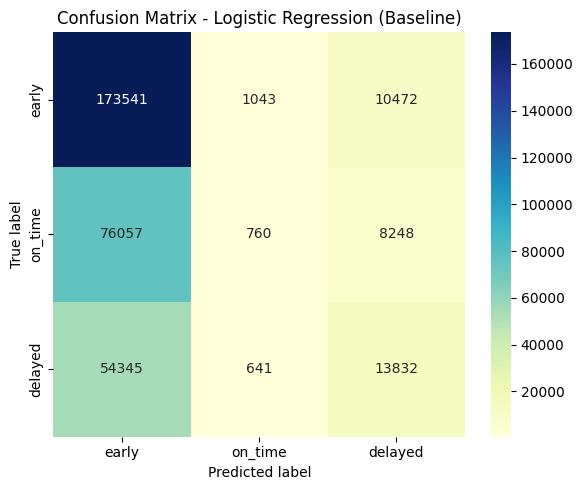

In [0]:
# Plot the headmap of the confusion matrix
confusion_pd = (pred_test
    .groupBy("label", "prediction")
    .count()
    .toPandas()
)

cm = (confusion_pd
      .pivot(index="label", columns="prediction", values="count")
      .fillna(0)
      .astype(int))

# StringIndexer model: numeric label -> string class name
indexer_model = baseline_lr_model.stages[0]
label_names = indexer_model.labels  # e.g., ['early', 'on_time', 'delayed']

# Ensure rows/cols sorted and then cast indices to int
cm = cm.reindex(index=sorted(cm.index), columns=sorted(cm.columns))

# Cast float indices (0.0,1.0,2.0) to int before using as list indices
row_labels = [label_names[int(i)] for i in cm.index]
col_labels = [label_names[int(j)] for j in cm.columns]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels, cmap="YlGnBu")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - Logistic Regression (Baseline)")
plt.tight_layout()
plt.show()


### One year data for training the model

In [0]:
# Function to build the model
def logistic_baseline(df):
    # Split train and test data
    train_df = df.filter(col("QUARTER").isin(1, 2, 3))
    test_df  = df.filter(col("QUARTER") == 4)

    # Identify numeric feature columns (baseline: numeric only, no extra encoding)
    label_col = 'DEP_DELAY_GROUP_CLASSIFIED'
    features_col = [
        c for c, t in df.dtypes
        if t in ("int", "bigint", "double", "float") and c != label_col and c != 'DEP_DELAY_GROUP'
    ]
    # Index the string label -> numeric label column
    label_indexer = StringIndexer(
        inputCol=label_col,
        outputCol="label",          
        handleInvalid="keep"
    )
    # Assemble numeric features into a single vector
    assembler = VectorAssembler(
        inputCols=features_col,
        outputCol="features"
    )
    # Define Logistic Regression model (multinomial for 3 classes)
    lr = LogisticRegression(
        featuresCol="features",
        labelCol="label",
        predictionCol="prediction",
        probabilityCol="probability",
        rawPredictionCol="rawPrediction",
        maxIter=50,
        regParam=0.0,        # no regularization for a very simple baseline
        elasticNetParam=0.0  # pure L2 would be 0.0 with regParam>0
    )

    # Build the pipeline (label indexer -> assembler -> logistic regression)
    baseline_lr_pipeline = Pipeline(stages=[label_indexer, assembler, lr])

    # Fit the model on the training set
    baseline_lr_model = baseline_lr_pipeline.fit(train_df)

    # Make predictions on the test set
    pred_test = baseline_lr_model.transform(test_df)

    # Evaluate baseline performance
    evaluator_acc = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="accuracy"
    )

    evaluator_f1 = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="f1"
    )

    test_accuracy = evaluator_acc.evaluate(pred_test)
    test_f1 = evaluator_f1.evaluate(pred_test)

    print(f"Baseline Logistic Regression (no CV)")
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Test F1-score: {test_f1:.4f}")

    # Plot the headmap of the confusion matrix
    confusion_pd = (pred_test
        .groupBy("label", "prediction")
        .count()
        .toPandas()
    )

    cm = (confusion_pd
        .pivot(index="label", columns="prediction", values="count")
        .fillna(0)
        .astype(int))

    # StringIndexer model: numeric label -> string class name
    indexer_model = baseline_lr_model.stages[0]
    label_names = indexer_model.labels  # e.g., ['early', 'on_time', 'delayed']

    # Ensure rows/cols sorted and then cast indices to int
    cm = cm.reindex(index=sorted(cm.index), columns=sorted(cm.columns))

    # Cast float indices (0.0,1.0,2.0) to int before using as list indices
    row_labels = [label_names[int(i)] for i in cm.index]
    col_labels = [label_names[int(j)] for j in cm.columns]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels, cmap="YlGnBu")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix - Logistic Regression (Baseline)")
    plt.tight_layout()
    plt.show()


Baseline Logistic Regression (no CV)
Test accuracy: 0.5946
Test F1-score: 0.4676


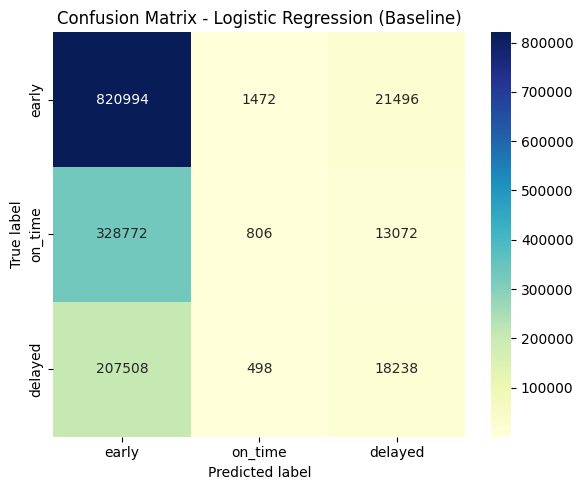

In [0]:
logistic_baseline(df_1y)
